In [1]:
# Import packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

# enough with the warnings!
warnings.simplefilter('ignore', np.RankWarning)
warnings.filterwarnings("ignore", module="matplotlib")
warnings.filterwarnings("ignore", module="statsmodels")

# PLOT STYLING
# Display plots in the notebook
%matplotlib inline 

#if you have jupyterthemes:
from jupyterthemes import jtplot
jtplot.style('grade3',context='paper', fscale=1.3)
jtplot.figsize(6, 6, 1.2)
# if you don't have jupyterthemes, but have seaborn you can use:
# sns.set(context='paper', rc={'figure.facecolor':'white'}, font_scale=1.7)

In [2]:
import itertools
import pandas as pd

def get_nodes(model, df, param='v', conditions=['variance', 'reward']):

    """ extract posterior distributions from hddm model for given parameter 
    Arguments:
       model is hddm model (after optimization has been run)
       df is the data you provided to the model when initializing
       param is model parameter to get posteriors for 
       conditions is list of exp. conditions param depends on
    Returns:
        list of stochastic nodes (with MCMC samples for param in each combination of conditions)
    """
    if len(conditions) > 1:    
        levels = [df[c].unique().tolist() for c in conditions] # identify levels of each conditions
        combined_lvls = list(itertools.product(*levels)) # identify all combinations of the levels via product
        nodes = ['{}{}'.format(param, str(lvls)) for lvls in combined_lvls] # create a string combining the parameter of interest with the condition levels
        nodes = [node.replace(', ','.') for node in nodes] # The string needs to mirror how it is referenced in hddm, so edit as needed.
    else:
        conditions = conditions[0]
        levels = df[conditions].unique().tolist()
        levels.sort()
        nodes = ['{}({})'.format(param, str(lvl)) for lvl in levels]
    return model.nodes_db.node[nodes] 
    
def compare_posteriors(cond1, cond2):
    """ compare posterior distributions for a parameter across conditions
    Arguments:
        cond1 and cond2 are each stochastic nodes 
            (from list of nodes returned by get_nodes()
    """
    mass_lt_zero = (cond1.trace() < cond2.trace()).mean()
    print("P(c1 < c2) = {:.6f}".format(mass_lt_zero))
    return mass_lt_zero

In [3]:
# Run the model if you don't have access to the parameters
#imports
import hddm
data = hddm.load_csv('D:/Rory/CoAx/Git/Pub_Code_master/Data/exp3data.csv')
#data grooming, remove fast outliers
rtSig = data.rt.std()
rtMu = data.rt.mean()
cutoff =  rtMu - rtSig
data = data[data.rt>cutoff]
data.reset_index(drop=True, inplace=True)
#build model
model = hddm.HDDM(data,depends_on={'v':['rwd_prob','stableVar'],'z':'rwd_prob'}, bias=True,
                        include=['v','a','t','z'], p_outlier=0.05)
model.find_starting_values()
model.sample(3000, burn=1000) # test right now

C:\Users\Rory\Anaconda3\lib\site-packages\IPython\parallel.py:13: ShimWarning: The `IPython.parallel` package has been deprecated. You should import from ipyparallel instead.
  "You should import from ipyparallel instead.", ShimWarning)
C:\Users\Rory\Anaconda3\lib\site-packages\scipy\optimize\optimize.py:1850: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
C:\Users\Rory\Anaconda3\lib\site-packages\pymc\Node.py:403: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.__name__ = input['__name__']


 [-----------------100%-----------------] 3001 of 3000 complete in 1237.6 sec

C:\Users\Rory\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)


In [4]:
df = pd.read_csv('D:/Rory/CoAx/Git/Pub_Code_master/Data/exp3data.csv')
param = 'v'
conditions = ['rwd_prob','stableVar']
vns = get_nodes(model, df, param, conditions)
vns

v(3.3)    v(3.3)
v(3.2)    v(3.2)
v(3.0)    v(3.0)
v(3.1)    v(3.1)
v(2.3)    v(2.3)
v(2.2)    v(2.2)
v(2.0)    v(2.0)
v(2.1)    v(2.1)
v(0.3)    v(0.3)
v(0.2)    v(0.2)
v(0.0)    v(0.0)
v(0.1)    v(0.1)
v(1.3)    v(1.3)
v(1.2)    v(1.2)
v(1.0)    v(1.0)
v(1.1)    v(1.1)
Name: node, dtype: object

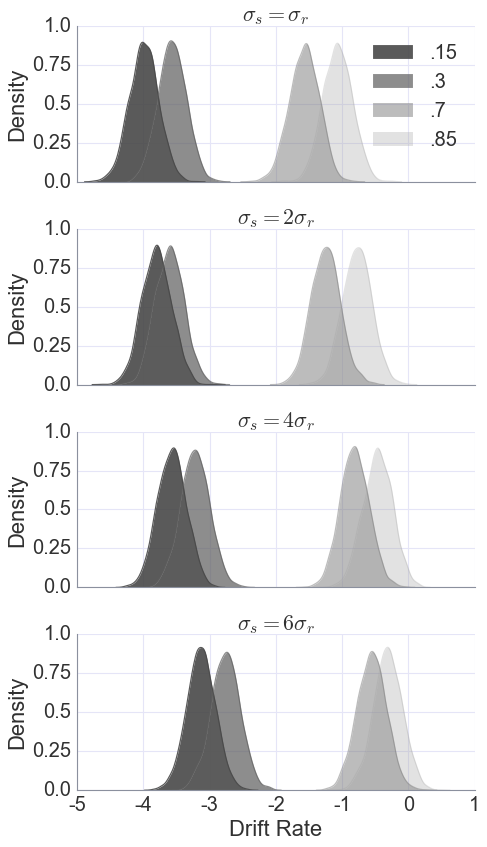

In [5]:
figs, axs = plt.subplots(4,1,sharex=True, figsize=(7,12))

cdict = sns.color_palette('Greys_d',4)
alphas = [.9,.7,.5,.3]
rps = [0,1,2,3]
vs = ['','2','4','6']
v = 0
for ax in axs:
    for rp in rps:
        sns.kdeplot(model['v(%i.%%i)'%rp%v].trace(), ax=ax,
                    shade=True, color=cdict[rp], alpha=alphas[rp]);
        ax.set_yticks(np.linspace(0,1,5))
        ax.set_yticklabels(np.linspace(0,1,5), fontsize=20)
        ax.set_ylim([0,1])
        ax.set_ylabel('Density', fontsize=22)
        ax.set_title('$\sigma_s = %s\sigma_r$'%vs[v], fontsize=22)
        
    if v == 0:
        ax.legend(['.15','.3','.7','.85'], loc='best', fontsize=20)
    if v == 3:
        ax.set_xlabel('Drift Rate', fontsize=22)
        ax.set_xticklabels(np.linspace(-5,3,9,dtype=int),fontsize=20)
        
    v += 1
sns.despine(top=True, right=True)
figs.savefig('driftrates3_byvar.png')
figs.savefig('driftrates3_byvar.eps')
figs.savefig('driftrates3_byvar.svg')

In [27]:
compare_posteriors(nodes['v(0.0)'],nodes['v(0.3)']);

NameError: name 'nodes' is not defined

In [6]:
param='z'
conditions= ['rwd_prob']
ns = get_nodes(model, df, param, conditions)
ns

z(0)    z(0)
z(1)    z(1)
z(2)    z(2)
z(3)    z(3)
Name: node, dtype: object

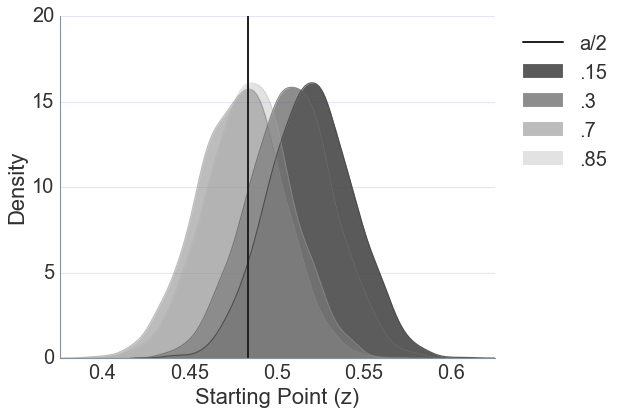

In [9]:
plt.figure()
for rp in range(4):
    ax = sns.kdeplot(model['%s'%ns[rp]].trace(),
               shade=True, color = cdict[rp], alpha=alphas[rp])
ax.set_xlabel('Starting Point (z)', fontsize=22)
ax.set_xticks(np.linspace(.4,.6,5))
ax.set_xticklabels(np.linspace(.4,.6,5), fontsize=20)
ax.set_yticks(np.linspace(0,20,5))
ax.set_yticklabels(np.linspace(0,20,5, dtype=int) ,fontsize=20)
ax.set_ylabel('Density',fontsize=22)
sns.despine(top=True,right=True)
plt.grid(axis='x');
plt.plot([model.values['a']/2, model.values['a']/2],[0, 20], color='k', lw=2);
lgd = plt.legend(['a/2','.15','.3','.7','.85'],bbox_to_anchor=(1.3,1), fontsize=20);
plt.savefig('onset3_byrp.png', bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.savefig('onset3_byrp.eps', bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.savefig('onset3_byrp.svg', bbox_extra_artists=(lgd,), bbox_inches='tight')